### 1. Reading data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

from scipy.stats import skew

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# importing custom matplotlib parameters for vizualizations
plt.rcParams['figure.figsize'] = (14,4)
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams["font.family"] = "monospace";

# Color Palettes
colors = ["#bfd3e6", "#9b5b4f", "#4e4151", "#dbba78", "#bb9c55", "#909195","#dc1e1e","#a02933","#716807","#717cb4"]
TGARGET = 'median_house_value'

In [3]:
data = pd.read_csv("data/housing.csv")
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
#describe the data with some visual style by applying T = Transpose and style
data.describe().T.style.bar(subset=['mean'],color=colors[3]).background_gradient(subset=['std','50%','max'])

,count,mean,std,min,25%,50%,75%,max
longitude,20640.000000,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
latitude,20640.000000,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
housing_median_age,20640.000000,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
total_rooms,20640.000000,2635.763081,2181.615252,2.000000,1447.750000,2127.000000,3148.000000,39320.000000
total_bedrooms,20433.000000,537.870553,421.385070,1.000000,296.000000,435.000000,647.000000,6445.000000
population,20640.000000,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
households,20640.000000,499.539680,382.329753,1.000000,280.000000,409.000000,605.000000,6082.000000
median_income,20640.000000,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
median_house_value,20640.000000,206855.816909,115395.615874,14999.000000,119600.000000,179700.000000,264725.000000,500001.000000


### 2. Check for missing values
- fill the nan values with median

In [7]:
data.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [8]:
data['total_bedrooms'].fillna(data['total_bedrooms'].median(), inplace= True)

In [9]:
num_cols = [col for col in data.columns if data[col].dtype in ['float64','int64']]
cat_cols = [col for col in data.columns if data[col].dtype not in ['float64','int64']]
print("Numerical columns: ", num_cols)
print("Categorical columns: ", cat_cols)

Numerical columns:  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
Categorical columns:  ['ocean_proximity']


### 3. Distribution of the target variable and explanatory variables
- Our target variable is clearly skewed, will need to apply log transformation
- Some other explanatory variables are also skewed

c:\Program Files\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Program Files\Python39\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


OptionError: "No such keys(s): 'mode.use_inf_as_null'"

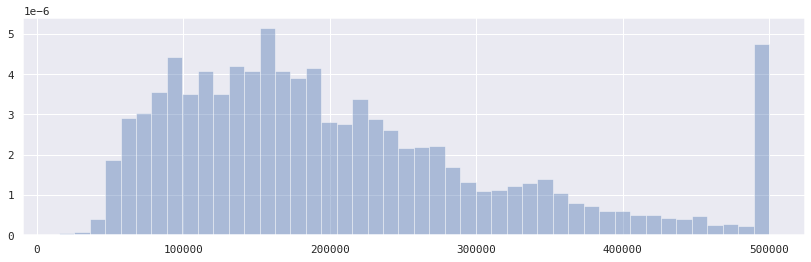

In [15]:
#checking the target variables for distribution
sns.distplot(data[TGARGET],color=colors[7])
plt.axvline(x=data[TGARGET].mean(), color=colors[7], linestyle='--', linewidth=2)
plt.title(TGARGET);
print("Skew: ", data['median_house_value'].skew())

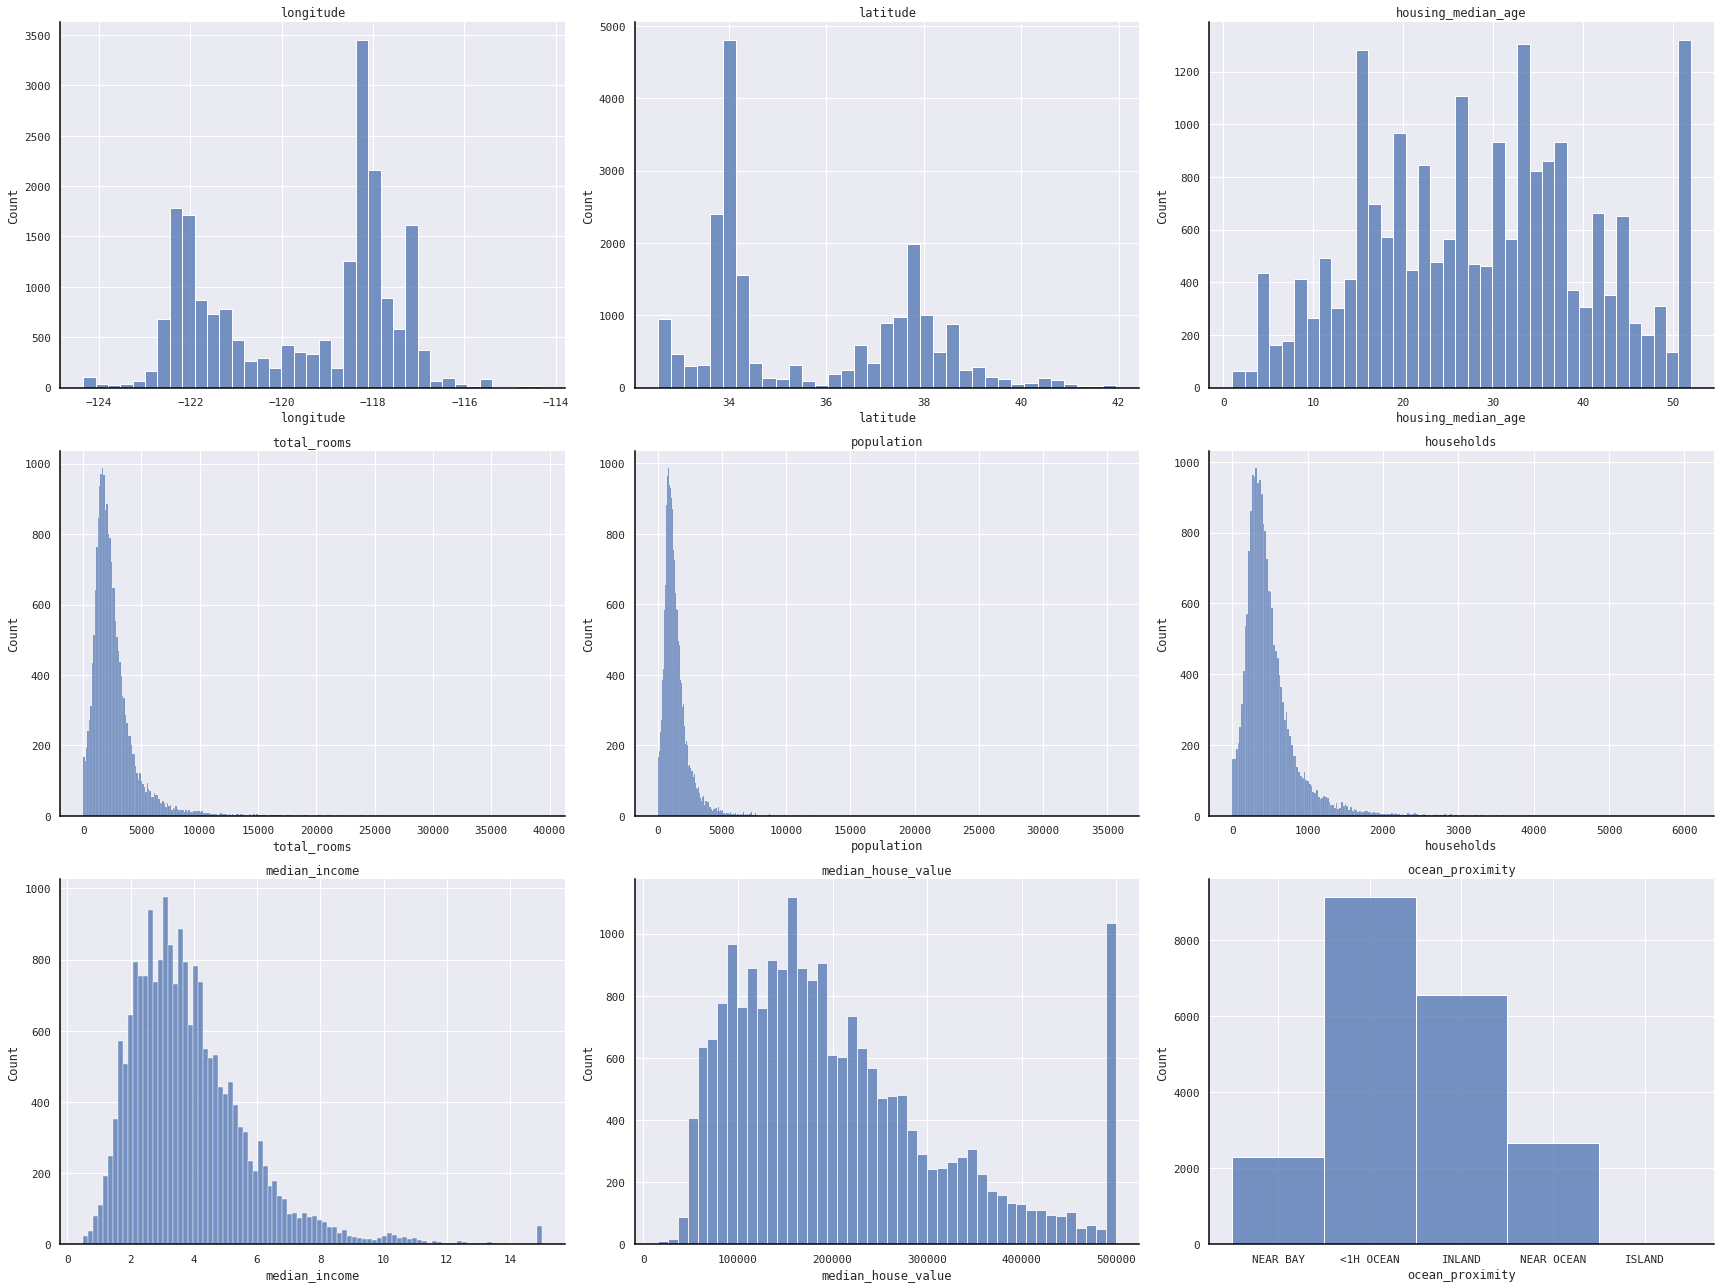

In [45]:
fig, axes = plt.subplots(3, 3, figsize=(24, 18))
data_num = data.loc[:, data.columns != 'total_bedrooms']
for i, col in enumerate(data_num.columns):
    sns.histplot(data[col], ax=axes[i//3, i%3])  # Use integer division and modulo to access the correct subplot
    axes[i//3, i%3].set_title(col)  # Set the title for each subplot
plt.tight_layout()
plt.show()

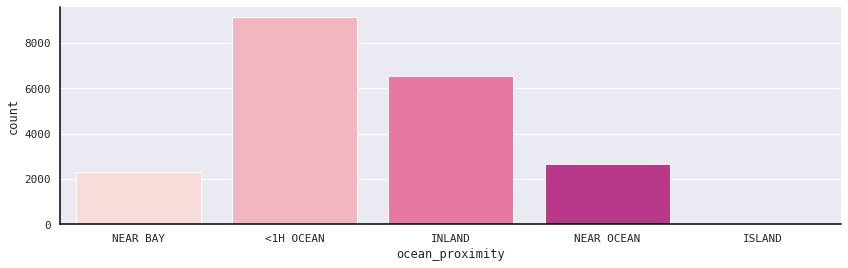

In [47]:
sns.countplot(x = data['ocean_proximity'], palette= 'RdPu');

### 4. Correlation matrix

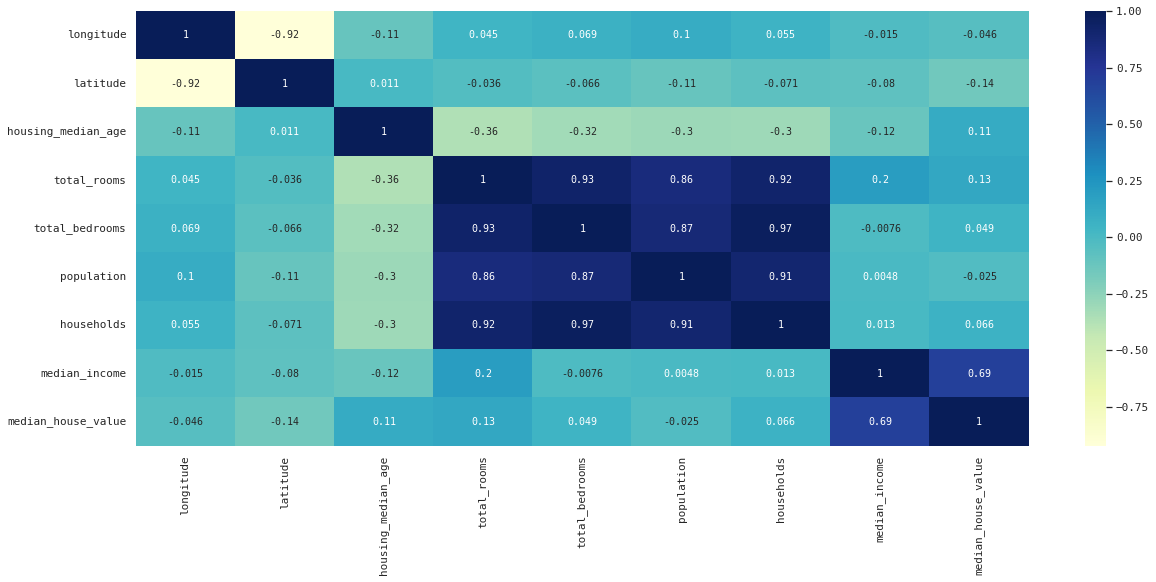

In [18]:
plt.figure(figsize= (20, 8))
sns.heatmap(data.corr(), annot= True, cmap='YlGnBu')
plt.show()

### 5. Feature engineering

In [50]:
data['bed_per_room'] = data['total_bedrooms'] / data['total_rooms']
X = data.drop(['median_house_value'], axis=1)
y = np.log(data.median_house_value) # Applying log transformation

In [60]:
# if abs(skew) > 0.5 -> it i skewed
skew_df = pd.DataFrame([col for col in X.columns if X[col].dtype in ['float64','int64']], columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: skew(X[feature]))
skew_df['Abs_Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Abs_Skew'].apply(lambda x: True if x > 0.5 else False)
skewed_columns = skew_df.loc[skew_df['Skewed'], 'Feature'].values
skew_df

,Feature,Skew,Abs_Skew,Skewed
0,longitude,-0.297780,0.297780,False
1,latitude,0.465919,0.465919,False
2,housing_median_age,0.060326,0.060326,False
3,total_rooms,4.147042,4.147042,True
4,total_bedrooms,3.480888,3.480888,True
5,population,4.935500,4.935500,True
6,households,3.410190,3.410190,True
7,median_income,1.646537,1.646537,True
8,bed_per_room,6.316445,6.316445,True


In [63]:
# take log transformation for those skewed columns in X
for column in skewed_columns:
    X[column] = np.log(X[column])

### 6. Encoding

In [64]:
encoder=LabelEncoder()
X['ocean_proximity']=encoder.fit_transform(X['ocean_proximity'])

### 7. Scaling and splitting data

In [66]:
X = pd.DataFrame(StandardScaler().fit_transform(X),  index= X.index, columns= X.columns)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

### 8. Training models and predictions

In [69]:
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

In [71]:
#making dictionary of models
models = {
    'SVR':SVR(),
    'XGBRegressor':XGBRegressor(),
    'Ridge':Ridge(),
    'ElasticNet':ElasticNet(),
    'SGDRegressor':SGDRegressor(),
    'BayesianRidge':BayesianRidge(),
    'LinearRegression':LinearRegression(),
    'RandomForestRegressor':RandomForestRegressor(),
    'KNN': KNeighborsRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor()
}

In [79]:
#taking results from the models
model_RMSE = []
model_names = list(models.keys())
model_predictions =  {key: [] for key in model_names}
# RMSE: root mean squared error
for name, model in models.items():
    a = model.fit(X_train, y_train)
    predicted = a.predict(X_test)
    model_predictions[name] = predicted
    score = np.sqrt(mean_squared_error(y_test, predicted))
    model_RMSE.append(score)
    #creating dataframe
    df_results = pd.DataFrame([model_names,model_RMSE])
    df_results = df_results.transpose()
    df_results = df_results.rename(columns={0:'Model',1:'RMSE'}).sort_values(by='RMSE',ascending=False)
print(df_results)

    

                    Model      RMSE
3              ElasticNet  0.569764
6        LinearRegression  0.345211
4            SGDRegressor   0.34441
5           BayesianRidge  0.344409
2                   Ridge  0.344409
8                     KNN  0.296013
0                     SVR  0.268412
9        GradientBoosting   0.26769
7   RandomForestRegressor  0.232885
1            XGBRegressor  0.228897
10                XGBoost  0.228897


In [85]:
selected_models = df_results.tail(10)['Model']

In [91]:
average_predictions = [0]*len(y_test)
for model in selected_models:
    average_predictions += model_predictions[model]*0.1
pd.DataFrame({'Actual': y_test, 'Predicted': average_predictions.round(2)})

,Actual,Predicted
20046,10.772687,11.04
3024,10.732039,11.44
15663,13.122365,12.61
20484,12.294999,12.45
9814,12.535376,12.47
...,...,...
15362,12.481049,12.28
16623,12.494255,12.30
18086,13.122365,13.03
2144,11.188579,11.41


#### Visualizing predictions

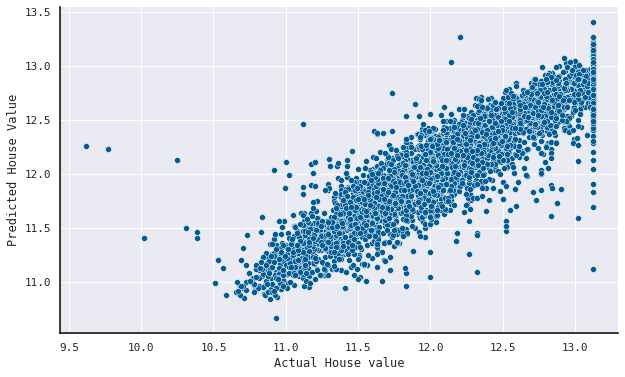

In [93]:
plt.figure(figsize= (10, 6))
sns.scatterplot(x= y_test, y= average_predictions, color= '#005b96')
plt.xlabel('Actual House value')
plt.ylabel('Predicted House Value')
plt.show()

In [95]:
np.corrcoef(y_test, average_predictions)

array([[1.        , 0.89051833],
       [0.89051833, 1.        ]])

#### Visualizing rediduals

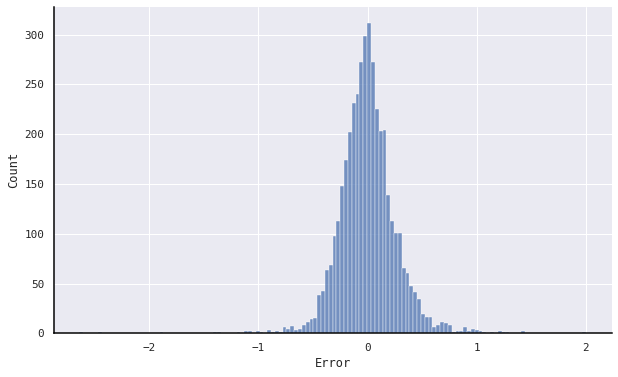

In [94]:
resid = y_test - average_predictions
plt.figure(figsize= (10, 6))
sns.histplot(resid)
plt.xlabel('Error');